In [8]:
import os
#abspath = os.path.abspath(__file__)
#dname = os.path.dirname(abspath)
#os.chdir(dname)

import torch
import torchvision
import sys
sys.path.append('../')
#sys.path.append('../file_helper.py')
from config import *
from tqdm import tqdm
from model import *
from file_helper import *

# DataLoader
import torchvision.transforms as T
from torchvision import transforms
from torchvision.transforms import ToTensor
from PIL import Image
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

#EVAL_NAME= "faster_rcnn_ep60_test_1k_0107"
EVAL_NAME= "___Test"
writer = SummaryWriter(EVAL_NAME)

from train import *
from PE_helper import *

transform = T.Compose([
        transforms.Resize((512, 1024)),
        T.ToTensor(),  # convert PIL image to PyTorch tensor
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize image
])

In [9]:
def uv_to_box(u,v):
    return np.array([u[0],v[0] , u[1],v[2] , u[1],v[3],u[0],v[1]]).reshape(-1,2)    

def split_cross_boundary_bbox (bbox , w = 2048 ):
    results= []
    bbox = bbox.flatten()
    max_gt = np.max(bbox.flatten())    
    if(max_gt>w):
        results.append(np.array([bbox[0]  ,bbox[1]  , w , bbox[1] , w , bbox[5] , bbox[0] , bbox[5]]))  
        results.append(np.array([0  ,bbox[1]  , bbox[2]%w , bbox[1] , bbox[2]%w , bbox[5] , 0,bbox[5]]))  
    else:
        results = [bbox]
    pass
    #results = np.array(results)
    return results
def xyxy_to_bbox_polygon(xyxy):
    return np.array([xyxy[0] ,xyxy[1] , xyxy[2],xyxy[1] , xyxy[2],xyxy[3] , xyxy[0] , xyxy[3]  ]).reshape(-1,2)

anno loaded  1000


  0%|          | 0/500 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


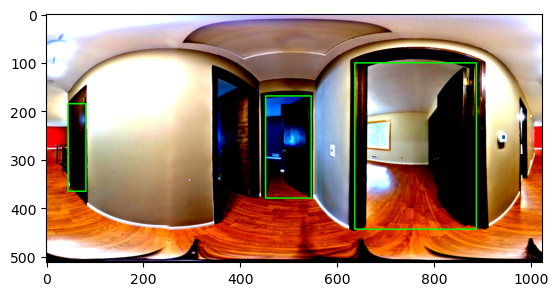

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


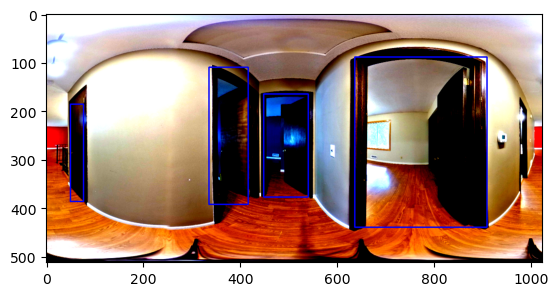

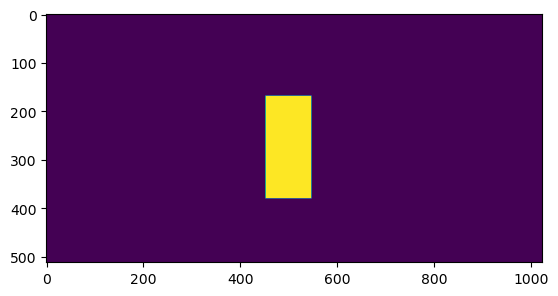

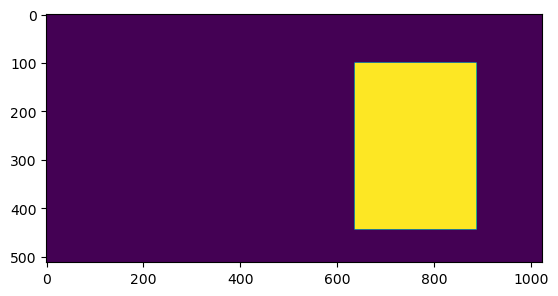

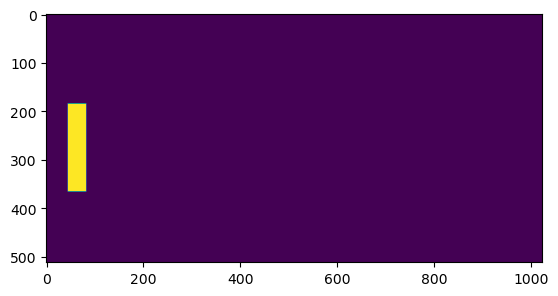

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


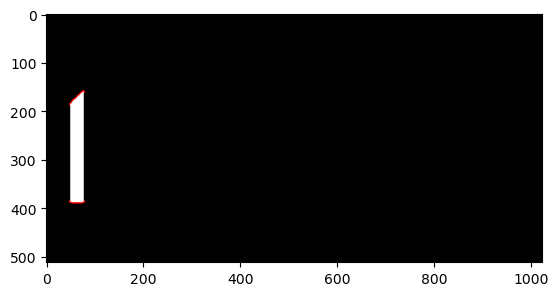

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


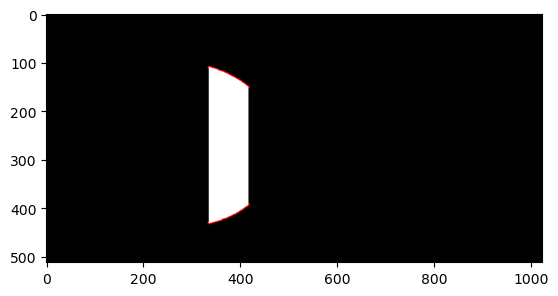

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


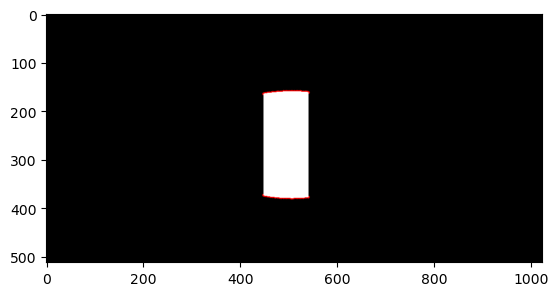

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


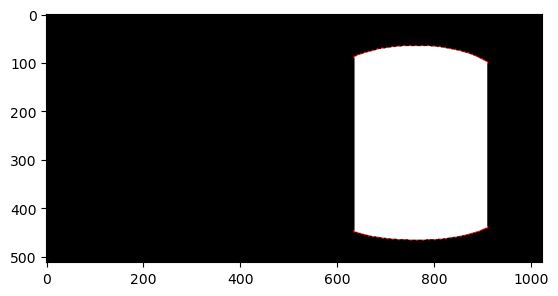

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


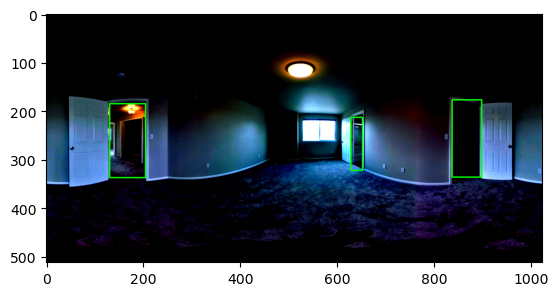

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


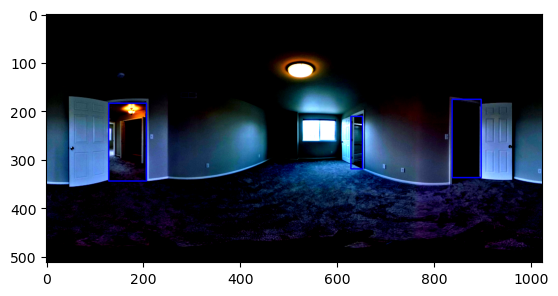

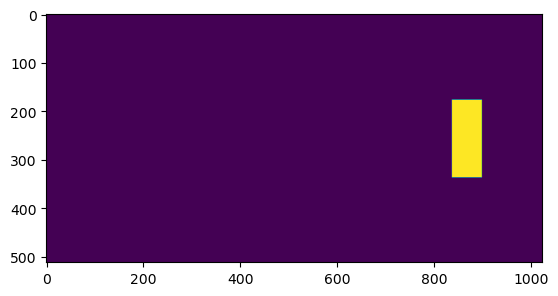

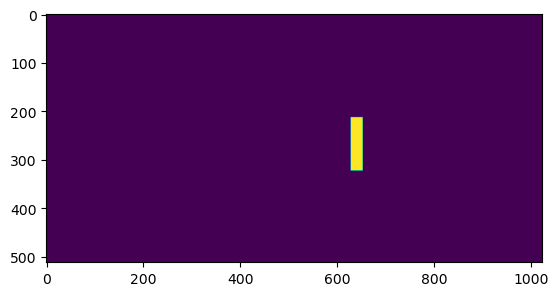

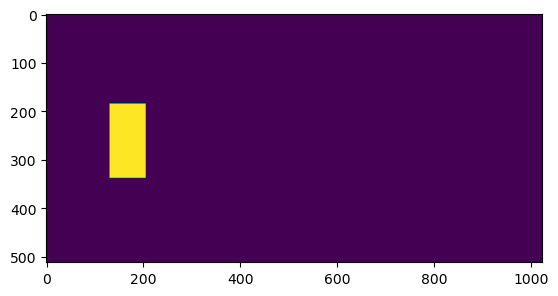

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


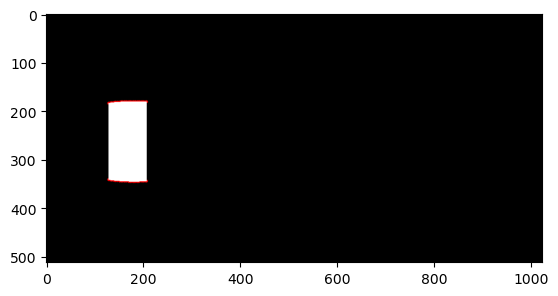

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


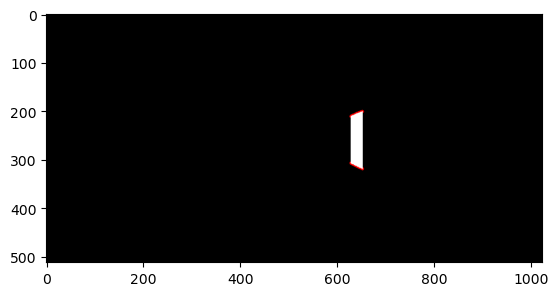

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


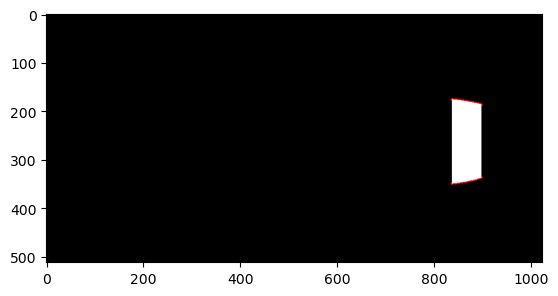

  0%|          | 0/500 [00:02<?, ?it/s]

gt_count 7
all_prediction [1 2 3 4 5 6]
recall [0.         0.14285714 0.28571429 0.42857143 0.57142857 0.71428571
 0.85714286]
precision [1. 1. 1. 1. 1. 1. 1.]
ap_0.05 0.8571428571428571
gt_count 7
all_prediction [1 2 3 4 5 6]
recall [0.         0.14285714 0.28571429 0.42857143 0.57142857 0.71428571
 0.85714286]
precision [1. 1. 1. 1. 1. 1. 1.]
ap_0.5 0.8571428571428571
gt_count 7
all_prediction [1 2 3 4 5 6]
recall [0.         0.14285714 0.28571429 0.28571429 0.42857143 0.57142857
 0.71428571]
precision [1.         1.         1.         0.66666667 0.75       0.8
 0.83333333]
ap_0.75 0.6142857142857143
all_iou 4.922254250224018
mIOU 0.7031791786034312


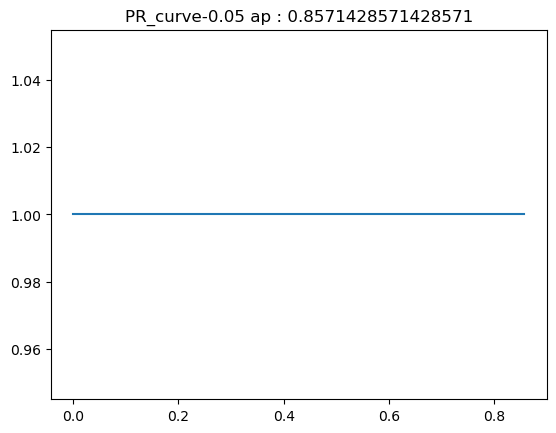

all_iou 4.922254250224018
mIOU 0.7031791786034312


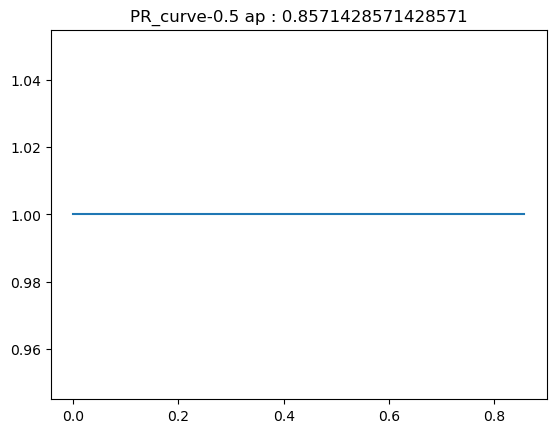

all_iou 4.922254250224018
mIOU 0.7031791786034312


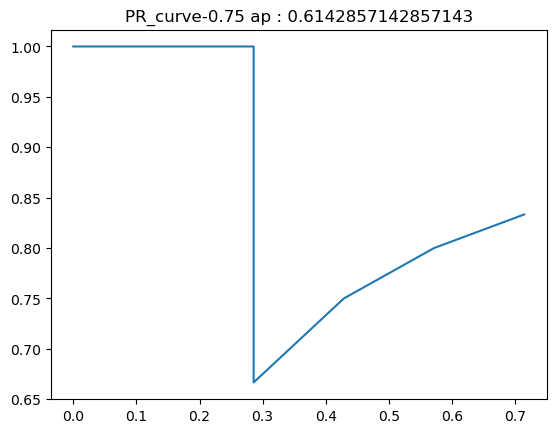

(array([1.        , 1.        , 1.        , 0.66666667, 0.75      ,
        0.8       , 0.83333333]),
 array([0.        , 0.14285714, 0.28571429, 0.28571429, 0.42857143,
        0.57142857, 0.71428571]),
 0.6142857142857143)

In [10]:
dataset_test = ZillowDataset(transforms=transform , anno_path= '../anno/test_visiable_1k_no_cross.json' )
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=2, shuffle=True, num_workers=0  , collate_fn = collate_fn )

pt_path = os.path.join(os.getcwd() , "checkpoints","ep60.pth")
model_2cls.load_state_dict(torch.load(pt_path))    
model_2cls = model_2cls.to('cuda')

model_2cls.eval()
eval_helper = PR_Eval_Helper(get_iou_fn = get_iou_matrix_pixel_level , writer= writer)

for data in tqdm(data_loader_test):
    img_b , anno_b = data
    anno_b_list = anno_to_list(anno_b)        
    output = model_2cls(img_b , anno_b_list)

    for img , out , gt in zip(img_b , output, anno_b):
        gt_seg_mask =[]
        out_bbox_mask=[]
        '''
        '''
        #==============================
        #           Debug
        #==============================
        # Pred
        debug_img =  debug_draw_bbox(img, out['boxes'].detach().cpu().numpy() , normalize=False)
        plt.imshow(debug_img)
        plt.show()
        
        # GT
        debug_img =  debug_draw_bbox(img, gt['boxes'].detach().cpu().numpy() , normalize=False , color=(0,0,255))
        plt.imshow(debug_img)
        plt.show()

        h,w = img.shape[-2:]
        gt_u , gt_v = torch.as_tensor(gt['u']) , torch.as_tensor(gt['v'])
        
        #============================
        #     Pred Bbox iou                    
        #============================
        for box in out['boxes']:            
            door_parts = split_cross_boundary_bbox(xyxy_to_bbox_polygon(box.detach().cpu().numpy()) , w=w)            
            
            _mask_canvas = np.zeros((h,w))
            for debug_door_part in door_parts:            
                debug_door_part = debug_door_part.reshape(-1,2)

                mask = cv2.fillPoly(_mask_canvas , [np.int32(debug_door_part )]  , (255,255,255) )
                plt.imshow(mask)
                plt.show()
                out_bbox_mask.append(mask)
            pass

        #============================
        #     GT Seg
        #============================
        gt_seg_u =  gt_u
        gt_seg_vt = gt_v.flatten()[::2].view(-1,2)
        gt_seg_vb = gt_v.flatten()[1::2].view(-1,2)
        for u,vt,vb in zip(gt_seg_u , gt_seg_vt , gt_seg_vb):
            polys , mask = to_distorted_box([u] , [vt] , [vb] , h=h , w = w , show_plt=True)            
            mask= np.max(mask,axis=2)
            gt_seg_mask.append(mask)
        
        
        eval_helper.eval_batch_pr(out_bbox_mask,gt_seg_mask ,None)



    break
eval_helper.get_all_pr()


In [11]:
print(eval_helper.get_iou_fn)

<function get_iou_matrix_pixel_level at 0x000001D9EAA0BD38>
